In [ ]:
# __file__ = "1.0-pr-initial-data-exploration.ipynb"
# BASE_DIR = os.path.dirname(os.path.dirname(os.path.dirname(os.path.abspath(__file__))))
# DATA_DIR = os.path.join(os.path.join(BASE_DIR, 'data'), 'raw_data')

# files_names = [file for file in os.listdir(DATA_DIR) if file.endswith('.csv')]
# dataframes = {}
# for file_name in files_names:
#     table_name = file_name.replace("olist_", "").replace("_dataset", "").replace(".csv","")
#     dataframes[table_name] = pd.read_csv(os.path.join(DATA_DIR, file_name))
#     print(f"Loading {table_name}")    

# Business Questions. 
_We want answers!_ 

**The company's business areas have some doubts and challenges such as:**


- Can we give the same benefits to all shopkeepers (sellers)? Or is there one that deserves to be highlighted?


- Is there a difference in the amount of freight charged in different regions, cities? Or can we apply the shipping subsidy rules to any location?


- Is our product catalog comprehensive? Or does it focus on specific categories?


- Do we always sell the same products? Or are there seasonalities?



**Dashboard showing:**
> Number of Orders Per Day.
>
> Number of Reviews Per Product.
>
> Number of Orders by Location.
>
> Number of Orders by Payment Method.
>
> Number of Reviews Per Customer.

# 0.0 Imports

In [1]:
import psycopg2

from IPython.display import Image

## 0.1 Helper Classes

In [2]:
class QueryBuilder:
    def __init__(self):
        self.select_value = ''
        self.from_table_name = ''
        self.where_value = ''
        self.groupby_value = ''
        self.limit_value = ''
        self.last_query_value = ''

    def select(self, select_arg):
        self.select_value = select_arg
        return self

    def from_table(self, from_arg):
        self.from_table_name = from_arg
        return self

    def where(self, where_arg):
        self.where_value = where_arg
        return self

    def groupby(self, groupby_args):
        self.groupby_value = groupby_args
        return self
    
    def limit(self, limit_args):
        self.limit_value = limit_args
        return self
    
    def reset(self):
        self.select_value = ''
        self.from_table_name = ''
        self.where_value = ''
        self.groupby_value = ''
        self.limit_value = ''
        return self
    
    def last_query(self):
        return self.last_query_value

    def build(self, reset=True):
        where_clause = ''
        groupby_clause = ''
        limit_clause = ''
        
        if self.where_value:
            where_clause = f'WHERE {self.where_value}'
        if self.groupby_value:
            groupby_clause = f'GROUP BY {self.groupby_value}'
        if self.limit_value:
            limit_clause = f'LIMIT {self.limit_value}'

        self.last_query_value = f"""
           SELECT {self.select_value}
           FROM {self.from_table_name}
           {where_clause}
           {groupby_clause}
           {limit_clause}
        """
        
        if reset:
            self.reset()
        
        return self.last_query_value

## 0.2  Helper Functions

In [9]:
def columns(table_name):
    cursor.execute( query.select("column_name").from_table("information_schema.columns")\
                   .where(f"table_name = '{table_name}'").build() )
    return [table[0] for table in cursor.fetchall()]

def rollback():
    cursor.execute("ROLLBACK;")

## 0.3 Loading Data

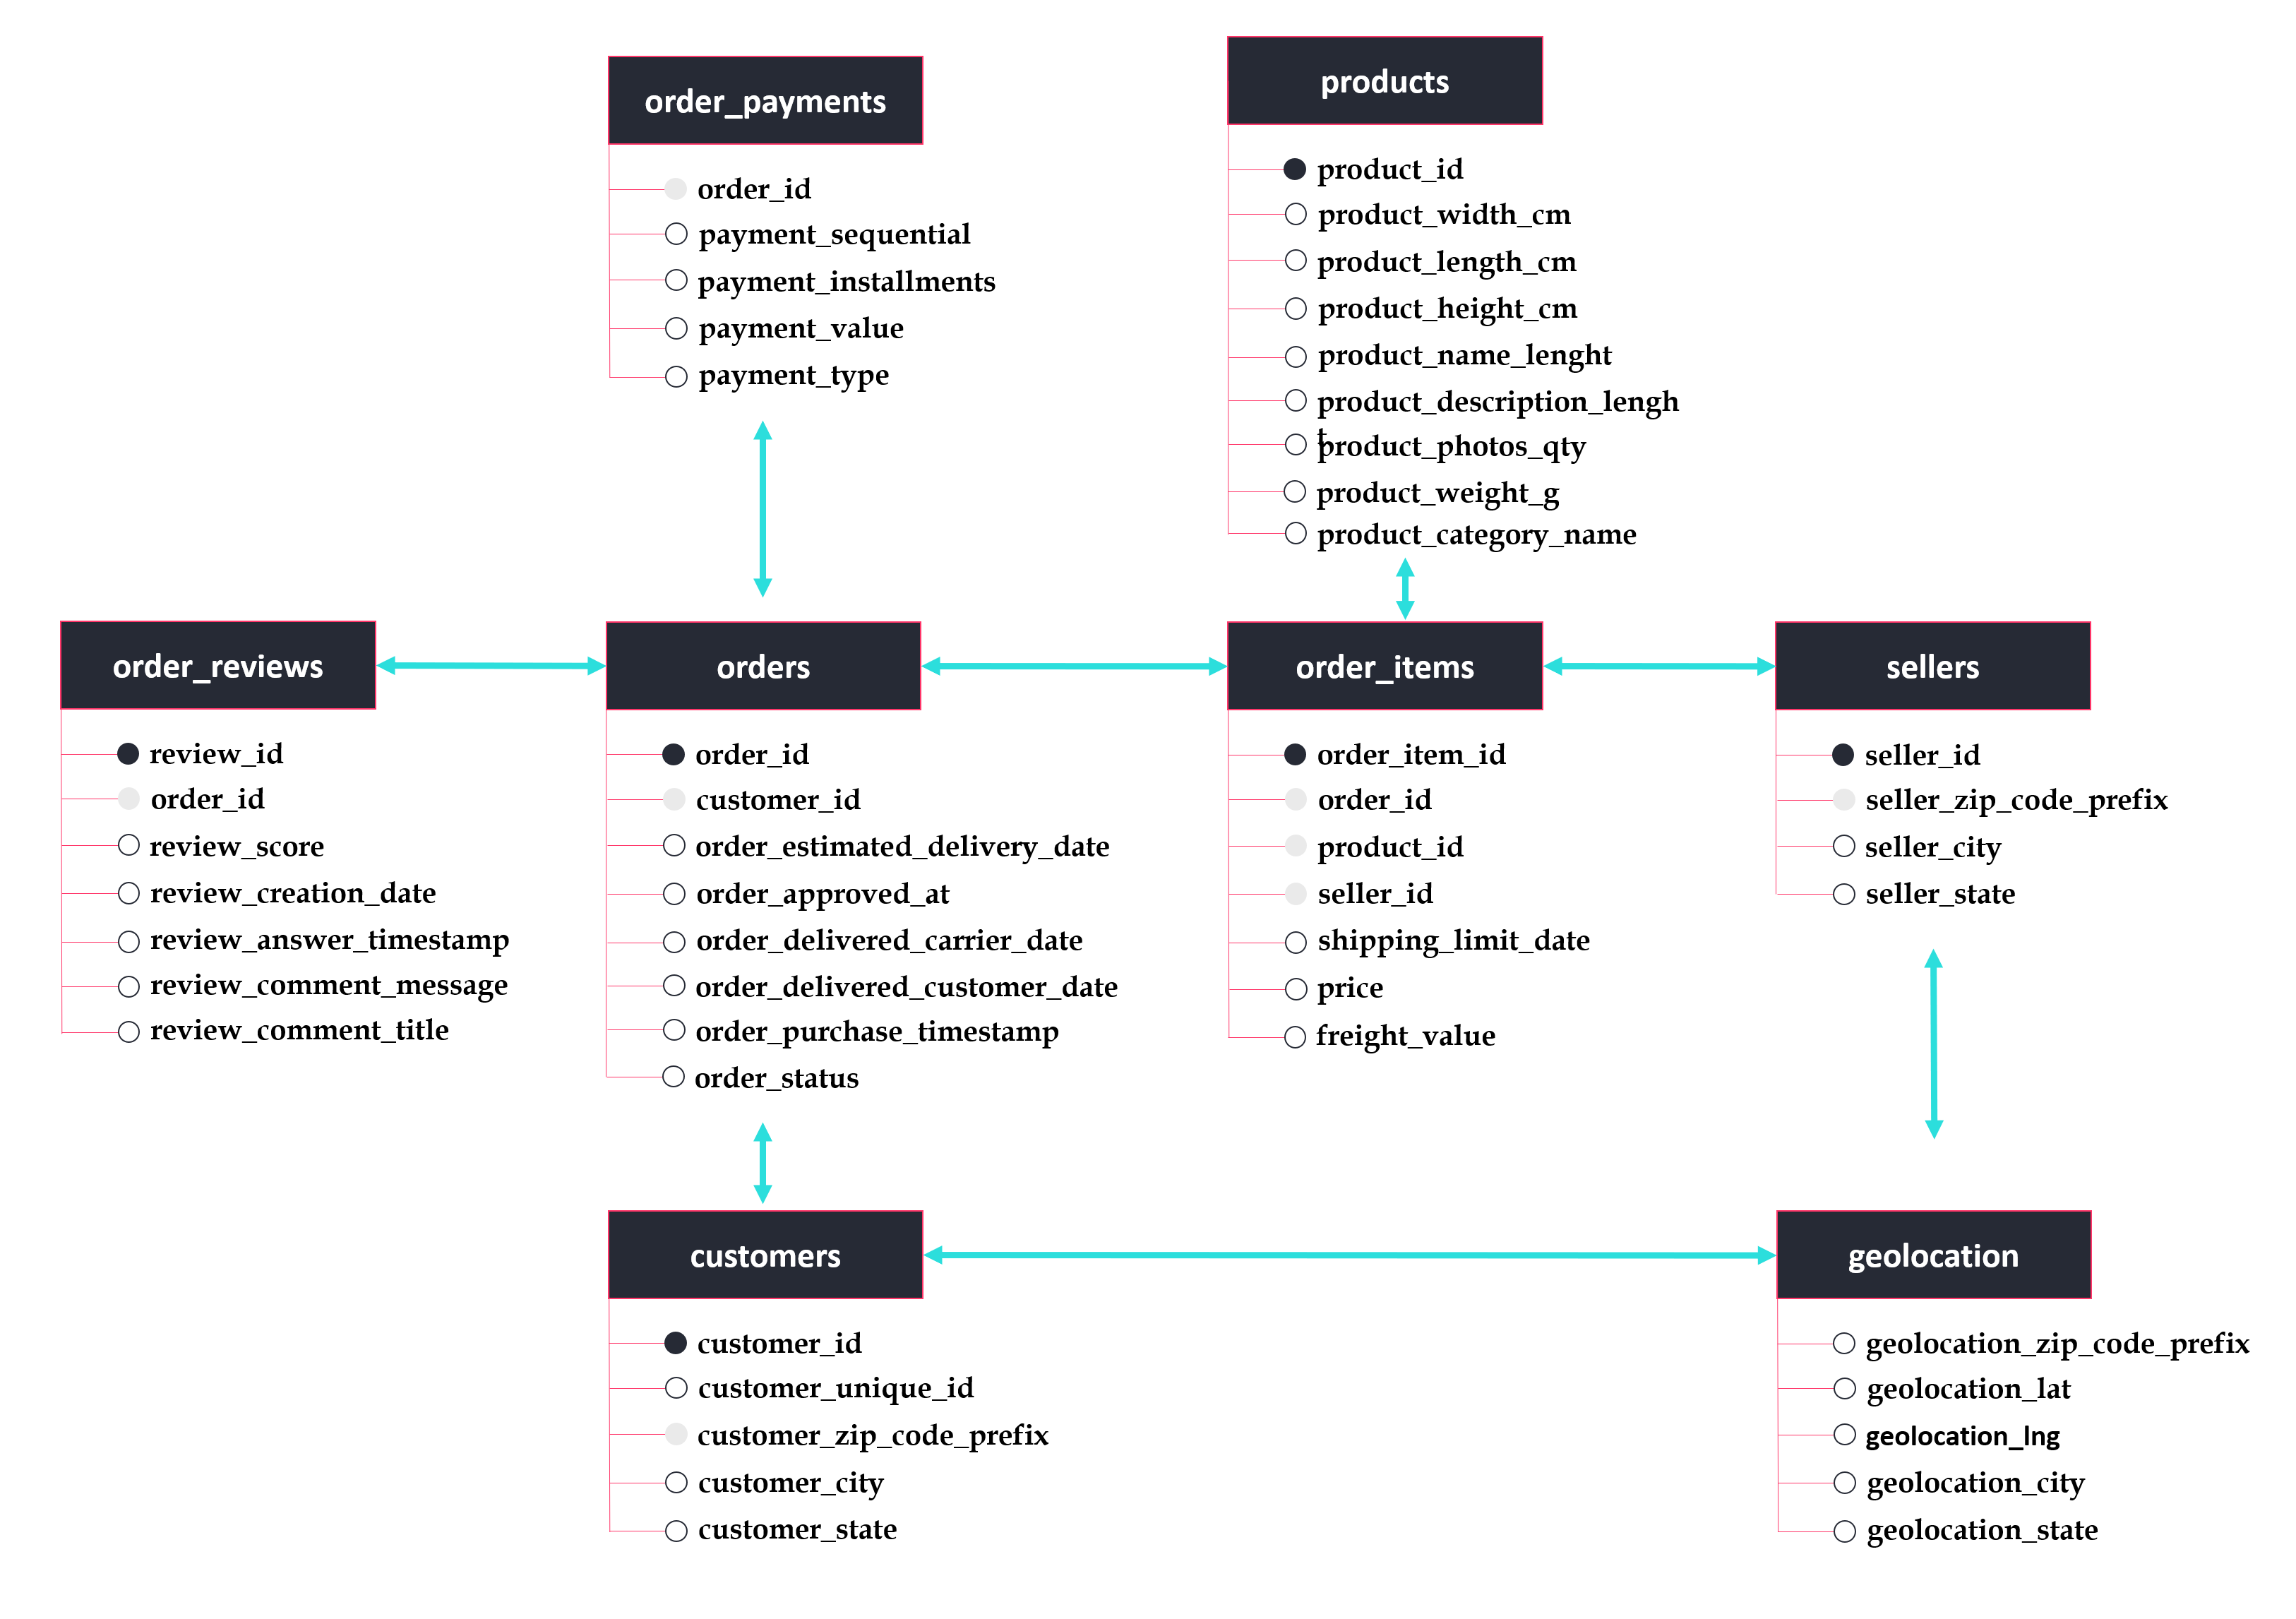

In [4]:
Image( '../images/mer.png' )

As my service was in stopped state somehow. "On windows, Just go to the 'Services'. Start/Restart the postgresql-X64 service".<br>
[stackoverflow](https://stackoverflow.com/questions/40532399/unable-to-connect-to-server-for-postgres)

In [11]:
conn = psycopg2.connect(host="localhost", user="postgres", password="07700770", database="postgres")
cursor = conn.cursor()

In [12]:
cursor.execute("""SELECT table_name FROM information_schema.tables WHERE table_schema = 'public'""")
tables = [table for table in cursor.fetchall()]
tables

[('order_items',),
 ('products',),
 ('sellers',),
 ('orders',),
 ('order_reviews',),
 ('order_payments',),
 ('geolocation',),
 ('customers',)]

In [13]:
query = QueryBuilder()
print(query.select("table_name").from_table("information_schema.tables").where("table_schema = 'public'").build())


           SELECT table_name
           FROM information_schema.tables
           WHERE table_schema = 'public'
           
           
        


## 2.0 Dashboard Queries

### 2.1 Number of Orders Per Day.

In [27]:
columns("orders")

['order_estimated_delivery_date',
 'order_approved_at',
 'order_delivered_carrier_date',
 'order_delivered_customer_date',
 'order_purchase_timestamp',
 'customer_id',
 'order_status',
 'order_id']

In [30]:
orders_per_day_query = query.select("order_approved_at::DATE as time, COUNT(order_id) as orders").from_table("orders")\
                       .groupby("time").limit(5).build()
cursor.execute(orders_per_day_query)
tables = [table for table in cursor.fetchall()]
tables

[(datetime.date(2016, 9, 15), 1),
 (datetime.date(2016, 10, 4), 20),
 (datetime.date(2016, 10, 5), 11),
 (datetime.date(2016, 10, 6), 110),
 (datetime.date(2016, 10, 7), 59)]